## WeatherPy: Weather Analysis Based on Latitude (6/12/2018)

Based on this analysis, latitude can only be used to predict temperature and demonstrates no relationship with a city's humidity, cloudiness, or wind speed.

To perform this analysis:
- To ensure a good sample of data, I generated 1,500 random, unique cities around the world using a combination of randomized latitude/longitude pairs and Citipy (to ensure I returned an actual city, not just a location on a map).
- To ensure that I didn't have false positives when determining if a city was a duplicate (for example, Bagdhad, Arizona and Baghdad, Iraq are two very different cities), I combined the city and county to create a hash of sorts.
- I pulled weather data that corresponded to those cities from OpenWeatherMap on 6/12/2018 at approximately 7:00 PM PST.

In [1]:
# -----------------------------------------------------------------------------------
# Step 1: Import the modules 
# -----------------------------------------------------------------------------------
import seaborn as sns
import json
import datetime as dt
import matplotlib.pyplot as plt
import requests as req
import pandas as pd
import random as rd
from citipy import citipy
import localenv
import aux

## City Data

In [2]:
# -----------------------------------------------------------------------------------
# Step 2: Store all our basic API data. I'd use params, but I couldn't get it to work
# with the unique structure of some of these parameters
# -----------------------------------------------------------------------------------

openWeatherURL = "http://api.openweathermap.org/data/2.5/weather?"

In [3]:
# -----------------------------------------------------------------------------------
# Step 3: Create a list of non-duplicate cities
# -----------------------------------------------------------------------------------
# create a list that we'll store all our data in
weatherData_list = []
city_list = []

# create dupe checking set
cityDupeChecker = set()

# create counter
i = 0

# create a list of 1500 possible cities (so even if a query fails still have good sample)
while len(cityDupeChecker) < 1500:
    
    # set random lat and long
    latitude = rd.uniform(-90.0,90.0)
    longitude = rd.uniform(-180.0,180.0)
    
    # get city
    city = citipy.nearest_city(latitude,longitude).city_name
    country = citipy.nearest_city(latitude,longitude).country_code
    city_country_pair = f"{city}_{country}"
    
    if city_country_pair not in cityDupeChecker:
        cityDupeChecker.add(city_country_pair)
        
        # try to pull in a random value and add to dupe checker
        city_list.append([city, country])

# -----------------------------------------------------------------------------------
# Step 4: Pull city data from openweatherapi
# -----------------------------------------------------------------------------------
for i in range(len(city_list)):
    
    # get current city and country
    city = city_list[i][0]
    country= city_list[i][1]
        
    # try searching by city + country code
    try:
        response = req.get(f"{openWeatherURL}q={city},{country}&units=imperial&APPID={localenv.api_key}").json()
        
        # add information from response to list
        weatherData_list.append({'cityID':response['id'],
                                 'date': dt.datetime.utcnow().strftime('%Y-%m-%d'),
                                 'time': dt.datetime.utcnow().strftime('%H:%M'),
                                 'city': response['name'],
                                 'country': country.upper(),
                                 'continent': aux.continentFromCountry(country.upper()),
                                 'latitude':response['coord']['lat'],
                                 'longitude':response['coord']['lon'],
                                 'humidity':response['main']['humidity'],
                                 'temperature':response['main']['temp'],
                                 'windSpeed':response['wind']['speed'],
                                 'cloudiness':response['clouds']['all'] })
        
        #show city
        #aux.displayProcessingCity(i,response)
    except:    
        try:
            response = req.get(f"{openWeatherURL}q={city}&units=metric&APPID={localenv.api_key}").json()
            
            # add information from response to list
            weatherData_list.append({'cityID':response['id'],
                                     'date': dt.datetime.now().strftime('%Y-%m-%d'),
                                     'time': dt.datetime.utcnow().strftime('%H:%M'),
                                     'city': response['name'],
                                     'country': response['main']['sys']['country'].upper(),
                                     'continent': aux.continentFromCountry(response['main']['sys']['country'].upper()),
                                     'latitude': response['coord']['lat'],
                                     'longitude': response['coord']['lon'],
                                     'humidity':response['main']['humidity'],
                                     'temperature':response['main']['temp'],
                                     'windSpeed':response['wind']['speed'],
                                     'cloudiness':response['clouds']['all']})
                                    
            #show city
            #aux.displayProcessingCity(i,response)
        except:
            #aux.displayFailedCity(i, city, country)
            pass

In [4]:
# -----------------------------------------------------------------------------------
# Step 4: Create a pretty dataframe that we can reference because visual aids are
# the actual best thing ever and export a CSV we can hang onto
# -----------------------------------------------------------------------------------
cleanedWeather_df = pd.DataFrame(weatherData_list)

# rearrange columns sensibly
cleanedWeather_df = cleanedWeather_df[['cityID', 'date', 'time', 'city', 'country', 'continent',
                                       'latitude', 'longitude',
                                       'temperature', 
                                       'humidity', 
                                       'windSpeed',
                                       'cloudiness']].sort_index(ascending=True)

# export the csv
date = dt.datetime.now().strftime('%Y-%m-%d')
filename = f"csv/WeatherData{date}.csv"
cleanedWeather_df.to_csv(filename)
cleanedWeather_df.head()

,cityID,date,time,city,country,continent,latitude,longitude,temperature,humidity,windSpeed,cloudiness
0,3833367,2018-06-13,02:24,Ushuaia,AR,South America,-54.81,-68.31,35.60,74,8.05,40
1,2077963,2018-06-13,02:24,Albany,AU,Oceania,-35.02,117.88,58.71,66,10.87,68
2,2123814,2018-06-13,02:24,Leningradskiy,RU,Europe,69.38,178.42,38.01,80,9.42,0
3,6165406,2018-06-13,02:24,Thompson,CA,North America,55.74,-97.86,64.40,45,5.82,75
4,5367788,2018-06-13,02:24,Lompoc,US,North America,34.64,-120.46,66.27,82,11.41,1


# Styling
To ensure a consistent look for the results, I established an overall color palette: husl, which is one of Seaborn's default palettes.

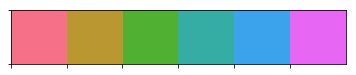

In [5]:
# parse palette into hex codes
palette = sns.color_palette('husl', n_colors=6)
hexCodes = palette.as_hex()

# create palette dict
palette_dict = {'Africa':hexCodes[0],
                'Oceania':hexCodes[1],
                'Europe':hexCodes[2],
                'North America':hexCodes[3],
                'South America':hexCodes[4],
                'Asia':hexCodes[5]}

# show palette
sns.palplot(palette)

# Review Cities to Ensure Good Distribution
After pulling my dataset, I wanted to review my dataset to ensure that I had good coverage of the world. The simplest way to do this was to visualize the location of all cities in my dataset.

In [6]:
import plotly.plotly as py
import plotly.graph_objs as go

data = [
    go.Scattermapbox(
        lat=cleanedWeather_df['latitude'],
        lon=cleanedWeather_df['longitude'],
        mode='markers',
        marker=dict(
            size=5,
            color='#5BAE7E',
            opacity=0.7
        ),
        text=cleanedWeather_df['city'] + ', ' + cleanedWeather_df['country'],
        hoverinfo='text'
    )]


layout = go.Layout(
    title= 'Cities Analyzed in Dataset',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=localenv.mapbox_api_key,
        bearing=0,
        pitch=0,
        zoom=0.5,
        style='dark'
    ),
)

fig = dict(data=data, layout=layout)

py.iplot(fig, filename=f'datapoints {date}')

# Plotting Our Data
## Latitude vs Temperature (F)
There is a definite relationship between latitude and temperature. As we approach the equator, or 0 degrees latitude, temperature increases.

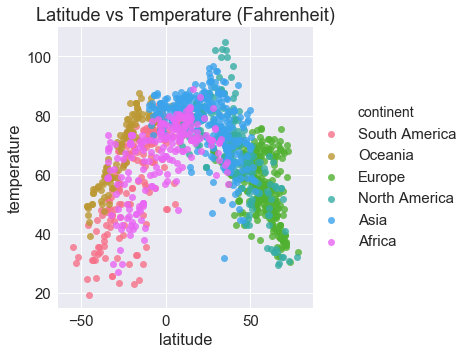

In [7]:
# -----------------------------------------------------------------------------------
# Step 5: Generate charts.
#  1) Temperature (F) vs. Latitude
#  2) Humidity (%) vs. Latitude
#  3) Cloudiness (%) vs. Latitude
#  4) Wind Speed (mph) vs. Latitude
# -----------------------------------------------------------------------------------
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Chart 1: Temperature vs Latitude
latVsTemp_plot = sns.lmplot(x='latitude', 
                            y='temperature', 
                            data=cleanedWeather_df,
                            hue='continent',
                            fit_reg=False, 
                            palette='husl')
plt.title("Latitude vs Temperature (Fahrenheit)")
plt.savefig("images/latXtemp.png")
plt.show()

In [8]:
# generate plotly scatter by continent
africa_scatter = aux.generateScatterPoints(cleanedWeather_df, 'Africa', 'latitude', 'temperature', palette_dict)
oceania_scatter = aux.generateScatterPoints(cleanedWeather_df, 'Oceania', 'latitude', 'temperature', palette_dict)                                           
europe_scatter = aux.generateScatterPoints(cleanedWeather_df, 'Europe', 'latitude', 'temperature', palette_dict)
northAmerica_scatter = aux.generateScatterPoints(cleanedWeather_df, 'North America', 'latitude','temperature', palette_dict)
southAmerica_scatter = aux.generateScatterPoints(cleanedWeather_df, 'South America', 'latitude', 'temperature', palette_dict)
asia_scatter = aux.generateScatterPoints(cleanedWeather_df, 'Asia', 'latitude', 'temperature', palette_dict)

# combine into single data list
data = [africa_scatter, oceania_scatter, europe_scatter, 
        northAmerica_scatter, southAmerica_scatter, asia_scatter]

layout = dict(title = 'Latitude vs Temperature', 
              hovermode='closest',
              xaxis=dict(title='Latitude', 
                         autorange=True), 
              yaxis=dict(title='Temperature (F)', 
                         autorange=True))

# plot data
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='latXtemp-fancy.png')

## Latitude vs Humidity (%)
There is no relationship between latitude and humidity.

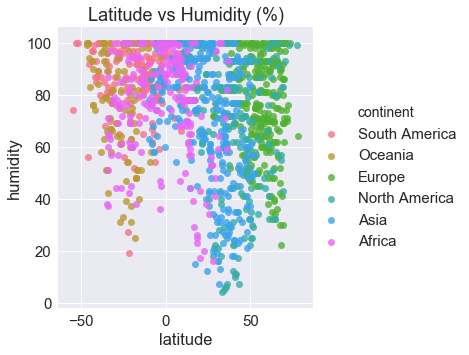

In [15]:
# Chart 2: humidity vs Latitude
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

latVsTemp_plot = sns.lmplot(x='latitude', 
                            y='humidity', 
                            data=cleanedWeather_df,
                            hue='continent',
                            palette='husl',
                            fit_reg=False)
plt.title("Latitude vs Humidity (%)")
plt.savefig("images/latXhumid.png")
plt.show()

In [16]:
# generate plotly scatter by continent
africa_scatter = aux.generateScatterPoints(cleanedWeather_df, 'Africa', 'latitude', 'humidity', palette_dict)
oceania_scatter = aux.generateScatterPoints(cleanedWeather_df, 'Oceania', 'latitude', 'humidity', palette_dict)                                           
europe_scatter = aux.generateScatterPoints(cleanedWeather_df, 'Europe', 'latitude', 'humidity', palette_dict)
northAmerica_scatter = aux.generateScatterPoints(cleanedWeather_df, 'North America', 'latitude','humidity', palette_dict)
southAmerica_scatter = aux.generateScatterPoints(cleanedWeather_df, 'South America', 'latitude', 'humidity', palette_dict)
asia_scatter = aux.generateScatterPoints(cleanedWeather_df, 'Asia', 'latitude', 'humidity', palette_dict)

# combine into single data list
data = [africa_scatter, oceania_scatter, europe_scatter, 
        northAmerica_scatter, southAmerica_scatter, asia_scatter]

layout = dict(title = 'Latitude vs Humidity', 
              hovermode='closest',
              xaxis=dict(title='Latitude', 
                         autorange=True), 
              yaxis=dict(title='Humidity (%)', 
                         autorange=True))

# plot data
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='latXhum-fancy.png')

## Latitude vs Cloudiness (%)
There is no relationship between latitude and cloudiness.

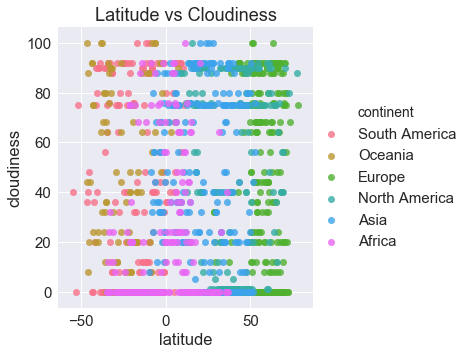

In [13]:
# Chart 3: cloudiness vs Latitude
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

latVsTemp_plot = sns.lmplot(x='latitude', y='cloudiness', 
                            data=cleanedWeather_df,
                            hue='continent',
                            palette='husl',
                            fit_reg=False)
plt.title("Latitude vs Cloudiness")
plt.savefig("images/latXcloud.png")
plt.show()

In [17]:
# generate plotly scatter by continent
africa_scatter = aux.generateScatterPoints(cleanedWeather_df, 'Africa', 'latitude', 'cloudiness', palette_dict)
oceania_scatter = aux.generateScatterPoints(cleanedWeather_df, 'Oceania', 'latitude', 'cloudiness', palette_dict)                                           
europe_scatter = aux.generateScatterPoints(cleanedWeather_df, 'Europe', 'latitude', 'cloudiness', palette_dict)
northAmerica_scatter = aux.generateScatterPoints(cleanedWeather_df, 'North America', 'latitude','cloudiness', palette_dict)
southAmerica_scatter = aux.generateScatterPoints(cleanedWeather_df, 'South America', 'latitude', 'cloudiness', palette_dict)
asia_scatter = aux.generateScatterPoints(cleanedWeather_df, 'Asia', 'latitude', 'cloudiness', palette_dict)

# combine into single data list
data = [africa_scatter, oceania_scatter, europe_scatter, 
        northAmerica_scatter, southAmerica_scatter, asia_scatter]

layout = dict(title = 'Latitude vs Cloudiness', 
              hovermode='closest',
              xaxis=dict(title='Latitude', 
                         autorange=True), 
              yaxis=dict(title='Cloudiness (%)', 
                         autorange=True))

# plot data
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='latXcloud-fancy.png')

## Latitude vs Wind Speed (MPH)
There is no apparent relationship between latitude and wind speed.

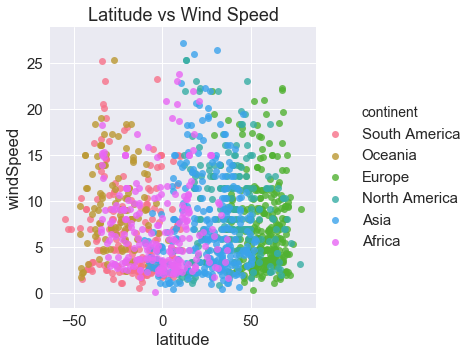

In [14]:
# Chart 4: wind speed vs Latitude
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

latVsTemp_plot = sns.lmplot(x='latitude', y='windSpeed', 
                            data=cleanedWeather_df,
                            hue='continent',
                            palette='husl',
                            fit_reg=False)
plt.title("Latitude vs Wind Speed")
plt.savefig("images/latXwind.png")
plt.show()

In [18]:
# generate plotly scatter by continent
africa_scatter = aux.generateScatterPoints(cleanedWeather_df, 'Africa', 'latitude', 'windSpeed', palette_dict)
oceania_scatter = aux.generateScatterPoints(cleanedWeather_df, 'Oceania', 'latitude', 'windSpeed', palette_dict)                                           
europe_scatter = aux.generateScatterPoints(cleanedWeather_df, 'Europe', 'latitude', 'windSpeed', palette_dict)
northAmerica_scatter = aux.generateScatterPoints(cleanedWeather_df, 'North America', 'latitude','windSpeed', palette_dict)
southAmerica_scatter = aux.generateScatterPoints(cleanedWeather_df, 'South America', 'latitude', 'windSpeed', palette_dict)
asia_scatter = aux.generateScatterPoints(cleanedWeather_df, 'Asia', 'latitude', 'windSpeed', palette_dict)

# combine into single data list
data = [africa_scatter, oceania_scatter, europe_scatter, 
        northAmerica_scatter, southAmerica_scatter, asia_scatter]

layout = dict(title = 'Latitude vs Cloudiness', 
              hovermode='closest',
              xaxis=dict(title='Latitude', 
                         autorange=True), 
              yaxis=dict(title='Wind Speed (MPH)', 
                         autorange=True))

# plot data
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='latXwind-fancy.png')